In [1]:
import os.path
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def download_data(file_name, url):
    if not os.path.isfile(file_name):
        urllib.request.urlretrieve(url, file_name)
        
url_lists = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2017-05-02/data/listings.csv.gz' 
url_calndr = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2017-05-02/data/calendar.csv.gz' 
url_revs = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2017-05-02/data/reviews.csv.gz'
url_nbs = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2017-05-02/visualisations/neighbourhoods.csv'
url_nbs_geo = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2017-05-02/visualisations/neighbourhoods.geojson'

url = [url_lists, url_calndr, url_revs, url_nbs, url_nbs_geo]

path_lists = 'listings.csv.gz'
path_calndr = 'calendar.csv.gz'
path_revs = 'reviews.csv.gz'
path_nbs = 'neighbourhoods.csv'
path_nbs_geo = 'neighbourhoods.geojson'

path = [path_lists, path_calndr, path_revs, path_nbs, path_nbs_geo]

for file_name, url in zip(path, url):
    download_data(file_name, url)

price_cutoff = 240
n_sample = 500

df_lists = pd.read_csv(path_lists, low_memory=False) 
df_revs = pd.read_csv(path_revs)
df_calndr = pd.read_csv(path_calndr)

df_lists.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,16228948,https://www.airbnb.com/rooms/16228948,20170502172350,2017-05-03,Robert Ranch in Los Angeles for filming/wedding,Stunning Ranch Estate situated on 20 acres and...,NaN,Stunning Ranch Estate situated on 20 acres and...,none,NaN,...,NaN,f,NaN,NaN,t,strict,f,f,1,NaN
1,8909380,https://www.airbnb.com/rooms/8909380,20170502172350,2017-05-03,Nice quiet private ranch house,NaN,Very private and quite . Hiking horse riding a...,Very private and quite . Hiking horse riding a...,none,I'm in the country what's not to love about that,...,9.0,f,NaN,NaN,f,flexible,f,f,1,1.91
2,14078522,https://www.airbnb.com/rooms/14078522,20170502172350,2017-05-03,Room w/private bath on Small Ranch,My place is close to Six Flags Magic Mountain ...,Room with queen bed and private bath,My place is close to Six Flags Magic Mountain ...,none,Horse area. Trails for hiking and riding. Quie...,...,10.0,f,NaN,NaN,f,flexible,f,f,1,1.72
3,13006928,https://www.airbnb.com/rooms/13006928,20170502172350,2017-05-03,Miller Ranch Bunkhouse,"Our place is close to great views, equestrian ...",Please know that we live on a dirt road but it...,"Our place is close to great views, equestrian ...",none,NaN,...,10.0,f,NaN,NaN,t,flexible,f,f,1,2.12
4,7898757,https://www.airbnb.com/rooms/7898757,20170502172350,2017-05-03,Studio with full bathroom,Fully furnished studio only a 10 min drive fro...,NaN,Fully furnished studio only a 10 min drive fro...,none,NaN,...,10.0,f,NaN,"City of Los Angeles, CA",f,flexible,f,f,1,0.18


In [2]:
df_lists.shape

(31253, 95)

In [3]:
print("The size of the dataset is {:.3f} Mb".format(getsizeof(df_lists)/(1024**2)))

The size of the dataset is 233.678 Mb


In [4]:
df_lists.price.head()

0    $3,000.00
1       $50.00
2       $55.00
3      $150.00
4       $30.00
Name: price, dtype: object

In [5]:
df_lists['price'] = df_lists['price'].replace('[\$,]', '', regex=True).astype(float)
df_lists.price.head()

0    3000.0
1      50.0
2      55.0
3     150.0
4      30.0
Name: price, dtype: float64

In [6]:
df_lists.price.describe()

count    31253.000000
mean       180.094039
std        418.502140
min         10.000000
25%         69.000000
50%        100.000000
75%        170.000000
max      10000.000000
Name: price, dtype: float64

In [7]:
df_lists.iloc[df_lists['price'].idxmax()]

id                                                                            9575442
listing_url                                      https://www.airbnb.com/rooms/9575442
scrape_id                                                              20170502172350
last_scraped                                                               2017-05-03
name                                                                 Bel Air Paradise
summary                             The spectacular Bel - Air Paradise Mansion in ...
space                                                         Beautiful Spanish style
description                         The spectacular Bel - Air Paradise Mansion in ...
experiences_offered                                                              none
neighborhood_overview                        It's one of the best neighborhoods in LA
notes                                                                             NaN
transit                                               

In [8]:
df_lists_cut = df_lists.query('price < @price_cutoff').copy()
df_sample = df_lists.price.sample(n_sample, random_state=2018)
df_lists_cut['price_cat'] = pd.cut(x=df_lists_cut.loc[:, ('price')], bins=[0, int(price_cutoff / 4), \
                                                                           int(2*price_cutoff / 4), \
                                                                           int(3*price_cutoff / 4), \
                                                                           price_cutoff])
df_lists_cut['price_cat'].value_counts()

(60, 120]     12061
(0, 60]        6415
(120, 180]     5765
(180, 240]     2407
Name: price_cat, dtype: int64

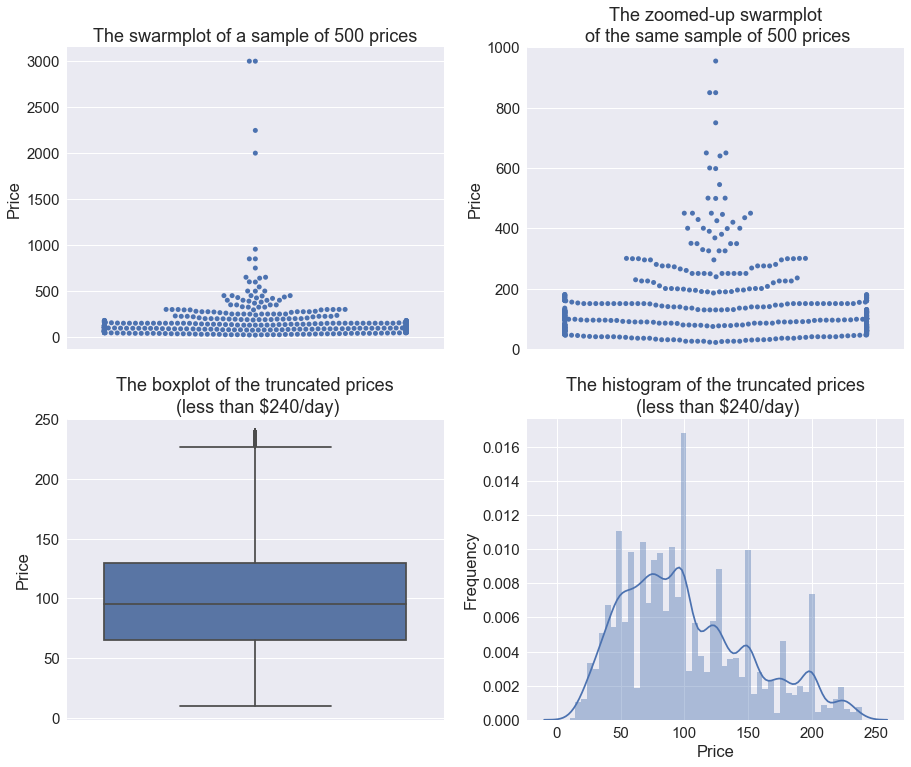

In [9]:
width = 13
height = 11
plt.figure(figsize=(width, height))
sns.set(font_scale=1.5)

plt.subplot(2, 2, 1)
sns.swarmplot(y=df_sample)
plt.title('The swarmplot of a sample of {} prices'.format(n_sample))
plt.ylabel('Price')

plt.subplot(2, 2, 2)
sns.swarmplot(y=df_sample)
plt.title('The zoomed-up swarmplot\n of the same sample of {} prices'.format(n_sample))
plt.ylabel('Price')
plt.ylim(0, 1000)

plt.subplot(2, 2, 3)
sns.boxplot(y=df_lists_cut.price)
plt.title('The boxplot of the truncated prices\n (less than ${}/day)'.format(price_cutoff))
plt.ylabel('Price')

plt.subplot(2, 2, 4)
sns.distplot(df_lists_cut.price)
plt.title('The histogram of the truncated prices\n (less than ${}/day)'.format(price_cutoff))
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()

plt.savefig('Fig_1_Prices.jpg')

In [10]:
df_lists.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [11]:
df_lists[['host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified']].head(10)

,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified
0,Robert,2016-01-12,"Los Angeles, California, United States",Thank You for considering my house for your ne...,a few days or more,25%,NaN,f,NaN,1.0,1.0,"['email', 'phone', 'reviews']",t,f
1,Kevin,2015-09-22,"Acton, California, United States",NaN,within an hour,100%,NaN,t,NaN,1.0,1.0,"['email', 'phone', 'reviews']",t,f
2,Kirsten,2016-07-19,"Palmdale, California, United States",NaN,within an hour,100%,NaN,t,NaN,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t
3,Beverly,2016-05-12,US,NaN,within an hour,100%,NaN,t,NaN,1.0,1.0,"['email', 'phone', 'reviews']",t,f
4,Ian,2015-08-16,US,NaN,NaN,NaN,NaN,f,West Adams,1.0,1.0,"['email', 'phone', 'reviews', 'jumio']",t,t
5,Dora,2016-01-11,"Los Angeles, California, United States",NaN,within a day,100%,NaN,f,West Adams,1.0,1.0,"['phone', 'facebook']",t,f
6,Cooper,2016-08-11,"Los Angeles, California, United States",I like what most of us like.\r\nTravel is expa...,within a few hours,96%,NaN,t,West Adams,2.0,2.0,"['email', 'phone', 'facebook', 'google', 'revi...",t,t
7,Elisabeth,2012-05-08,"Los Angeles, California, United States",LA ROOM RENTALS\r\nWe rent out furnished rooms...,within a few hours,96%,NaN,f,Hollywood,23.0,23.0,"['email', 'phone', 'reviews', 'kba']",t,t
8,Jacob,2016-09-01,US,NaN,NaN,NaN,NaN,f,West Adams,1.0,1.0,"['email', 'phone', 'google', 'kba']",t,t
9,Kelley,2014-12-16,"Los Angeles, California, United States",I am fun and quite social. I enjoy it when peo...,within an hour,100%,NaN,t,West Adams,2.0,2.0,"['email', 'phone', 'reviews', 'jumio']",t,t


In [12]:
df_lists_cut.host_is_superhost.value_counts()

f    21190
t     5446
Name: host_is_superhost, dtype: int64

In [13]:
df_lists_cut['host_is_superhost'] = df_lists_cut['host_is_superhost'].replace({'t':True, 'f':False})

In [14]:
host = df_lists_cut.groupby(['host_is_superhost', 'price_cat'])['id'].size().reset_index(name="total_number")
host

,host_is_superhost,price_cat,total_number
0,False,"(0, 60]",5459
1,False,"(60, 120]",9423
2,False,"(120, 180]",4432
3,False,"(180, 240]",1876
4,True,"(0, 60]",954
5,True,"(60, 120]",2633
6,True,"(120, 180]",1329
7,True,"(180, 240]",530


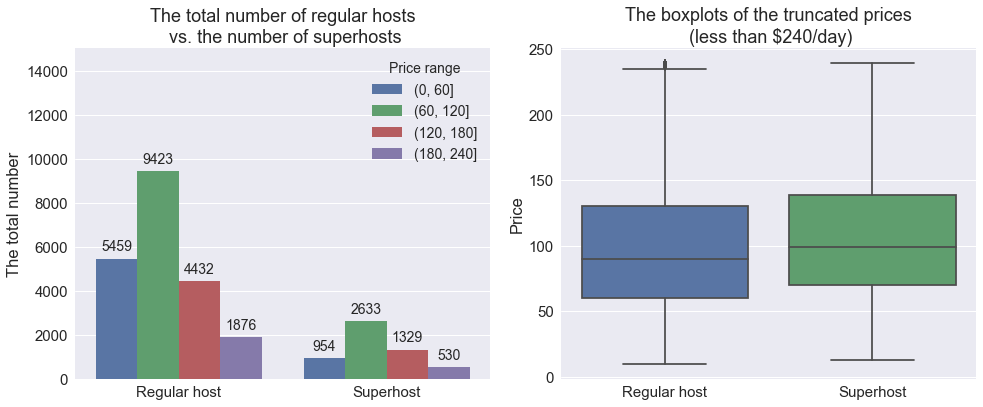

In [15]:
width = 14
height = 6
plt.figure(figsize=(width, height))
sns.set(font_scale=1.5)

plt.subplot(1, 2, 1)

ax_1 = sns.barplot(x = 'host_is_superhost', y='total_number', data=host, hue='price_cat')
ax_1.set(xlabel='',
       ylabel='The total number', \
       title= 'The total number of regular hosts\n vs. the number of superhosts', \
       xticklabels=['Regular host', 'Superhost'], ylim=(0, 15000))

for p in ax_1.patches:
    height = p.get_height()
    ax_1.text(p.get_x()+p.get_width()/2.,
            height + 350,
            '{:1.0f}'.format(height), fontsize=14,
            ha="center") 

ax_1.legend(title='Price range')
plt.setp(ax_1.get_legend().get_texts(), fontsize='14')
plt.setp(ax_1.get_legend().get_title(), fontsize='14')

plt.subplot(1, 2, 2)

ax_2 = sns.boxplot(x='host_is_superhost', y='price', data=df_lists_cut)

ax_2.set(xlabel='',
       ylabel='Price', \
       title="The boxplots of the truncated prices\n (less than ${}/day)".format(price_cutoff), \
       xticklabels=['Regular host', 'Superhost'])

plt.tight_layout()

plt.savefig('Fig_2_Superhosts.jpg')

plt.show()

In [16]:
h_neighbs = df_lists_cut.host_neighbourhood.value_counts()[1:40]
print(h_neighbs)

Hollywood                       1904
Venice                          1250
West Hollywood                   888
Long Beach                       762
Santa Monica                     650
Silver Lake                      546
Echo Park                        539
Downtown                         472
Hollywood Hills                  467
Westlake                         429
North Hollywood                  420
Mar Vista                        413
Pasadena                         386
South LA                         375
West Los Angeles                 372
Westwood                         331
Westchester/Playa Del Rey        303
Sherman Oaks                     286
Del Rey                          285
South Robertson                  283
Mid-City                         274
East Hollywood                   273
Burbank                          246
Los Feliz                        242
Beverly Hills                    225
Glendale                         217
Marina Del Rey                   215
H

In [17]:
h_neighbs = h_neighbs.index.values
print(h_neighbs)

['Hollywood' 'Venice' 'West Hollywood' 'Long Beach' 'Santa Monica'
 'Silver Lake' 'Echo Park' 'Downtown' 'Hollywood Hills' 'Westlake'
 'North Hollywood' 'Mar Vista' 'Pasadena' 'South LA' 'West Los Angeles'
 'Westwood' 'Westchester/Playa Del Rey' 'Sherman Oaks' 'Del Rey'
 'South Robertson' 'Mid-City' 'East Hollywood' 'Burbank' 'Los Feliz'
 'Beverly Hills' 'Glendale' 'Marina Del Rey' 'Highland Park'
 'Woodland Hills/Warner Center' 'Redondo Beach' 'Culver City' 'Westside'
 'Studio City' 'West Adams' 'Palms' 'Brentwood' 'Altadena' 'Topanga'
 'Eagle Rock']


In [18]:
mask = df_lists_cut['host_neighbourhood'].isin(h_neighbs)
mask[0:10]

1     False
2     False
3     False
4      True
5      True
6      True
7      True
9      True
10     True
11     True
Name: host_neighbourhood, dtype: bool

In [19]:
price_order = df_lists_cut[mask].groupby('host_neighbourhood')['price'].median().sort_values(ascending=False).index.values
print(price_order)

['Marina Del Rey' 'Downtown' 'Venice' 'Beverly Hills' 'Topanga' 'Westwood'
 'Santa Monica' 'West Hollywood' 'Hollywood Hills' 'Silver Lake'
 'West Los Angeles' 'Studio City' 'Los Feliz' 'Pasadena' 'Hollywood'
 'Del Rey' 'Westchester/Playa Del Rey' 'Brentwood' 'Culver City'
 'Echo Park' 'South Robertson' 'Westside' 'Glendale' 'Redondo Beach'
 'Sherman Oaks' 'Long Beach' 'East Hollywood' 'Burbank' 'Altadena'
 'Highland Park' 'Eagle Rock' 'Mar Vista' 'Westlake' 'Mid-City'
 'Woodland Hills/Warner Center' 'North Hollywood' 'Palms' 'West Adams'
 'South LA']


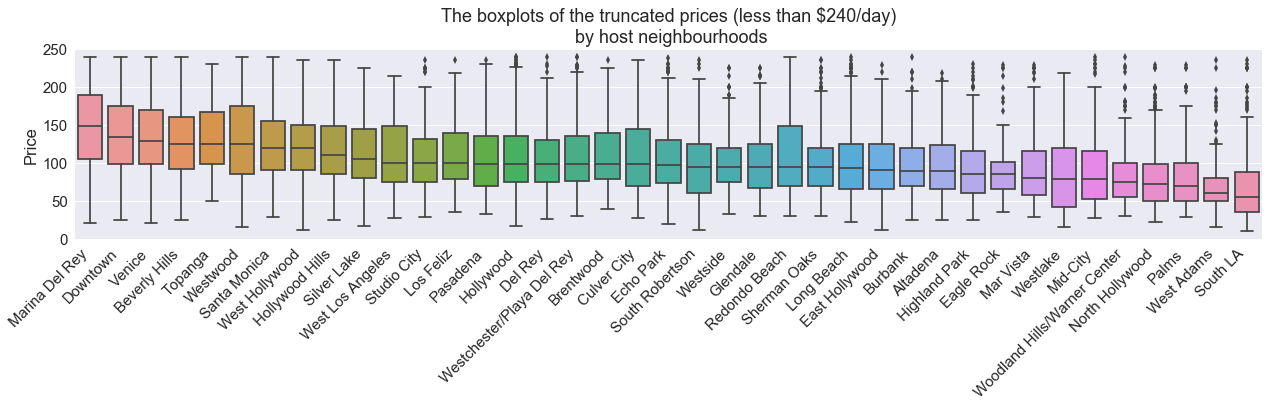

In [20]:
width = 18
height = 6
plt.figure(figsize=(width, height))
sns.set(font_scale=1.5)

ax = sns.boxplot(x='host_neighbourhood', y='price', data=df_lists_cut[mask], order=price_order)

ax.set(xlabel= '',
       ylabel='Price', \
       title="The boxplots of the truncated prices (less than ${}/day)\n by host neighbourhoods".format(price_cutoff))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

plt.savefig('Fig_3_Host_neigbourhood.jpg')

plt.show()

In [21]:
df_lists_cut[['street','neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 
          'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact']].head()

,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact
1,"Palmdale, CA 93550, United States",NaN,Acton,NaN,Palmdale,CA,93550,Other (Domestic),"Palmdale, CA",US,United States,34.485431,-118.125380,f
2,"Acton, CA 93510, United States",NaN,Acton,NaN,Acton,CA,93510,Other (Domestic),"Acton, CA",US,United States,34.510130,-118.212407,t
3,"Acton, CA 93510, United States",NaN,Acton,NaN,Acton,CA,93510,Other (Domestic),"Acton, CA",US,United States,34.515486,-118.230742,t
4,"West Adams, Los Angeles, CA 90007, United States",West Adams,Adams-Normandie,NaN,Los Angeles,CA,90007,Los Angeles,"Los Angeles, CA",US,United States,34.031419,-118.299016,t
5,"West Adams, Los Angeles, CA 90007, United States",West Adams,Adams-Normandie,NaN,Los Angeles,CA,90007,Los Angeles,"Los Angeles, CA",US,United States,34.026601,-118.293544,t


In [22]:
neighbs = df_lists_cut.neighbourhood_cleansed.value_counts()[1:40]
print(neighbs)

Venice                  1517
Long Beach              1001
Santa Monica             782
Downtown                 776
West Hollywood           748
Mid-Wilshire             666
Silver Lake              624
Koreatown                607
Hollywood Hills          582
Echo Park                537
Westlake                 465
Pasadena                 462
Sawtelle                 461
North Hollywood          434
Beverly Grove            429
East Hollywood           414
Los Feliz                408
Westwood                 391
Mid-City                 382
Mar Vista                353
Sherman Oaks             343
Rowland Heights          340
Fairfax                  322
Palms                    302
Studio City              294
Del Rey                  293
Beverly Hills            276
Hollywood Hills West     269
Glendale                 268
Burbank                  247
Highland Park            244
Redondo Beach            228
Culver City              225
Woodland Hills           222
Pico-Union    

In [23]:
neighbs = neighbs.index.values
print(neighbs)

['Venice' 'Long Beach' 'Santa Monica' 'Downtown' 'West Hollywood'
 'Mid-Wilshire' 'Silver Lake' 'Koreatown' 'Hollywood Hills' 'Echo Park'
 'Westlake' 'Pasadena' 'Sawtelle' 'North Hollywood' 'Beverly Grove'
 'East Hollywood' 'Los Feliz' 'Westwood' 'Mid-City' 'Mar Vista'
 'Sherman Oaks' 'Rowland Heights' 'Fairfax' 'Palms' 'Studio City' 'Del Rey'
 'Beverly Hills' 'Hollywood Hills West' 'Glendale' 'Burbank'
 'Highland Park' 'Redondo Beach' 'Culver City' 'Woodland Hills'
 'Pico-Union' 'Pico-Robertson' 'Van Nuys' 'Arcadia' 'Westchester']


In [24]:
mask = df_lists_cut['neighbourhood_cleansed'].isin(neighbs)
mask[0:10]

1     False
2     False
3     False
4     False
5     False
6     False
7     False
9     False
10    False
11    False
Name: neighbourhood_cleansed, dtype: bool

In [25]:
price_order = df_lists_cut[mask].groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=False).index.values
print(price_order)

['Venice' 'Beverly Hills' 'Downtown' 'Santa Monica' 'Westwood'
 'West Hollywood' 'Fairfax' 'Hollywood Hills West' 'Beverly Grove'
 'Silver Lake' 'Hollywood Hills' 'Mid-Wilshire' 'Sawtelle' 'Pasadena'
 'Redondo Beach' 'Studio City' 'Pico-Robertson' 'Echo Park' 'Culver City'
 'Del Rey' 'Sherman Oaks' 'Los Feliz' 'Westchester' 'Glendale' 'Long Beach'
 'Burbank' 'East Hollywood' 'Westlake' 'Highland Park' 'Mar Vista'
 'Arcadia' 'Mid-City' 'Woodland Hills' 'Palms' 'Koreatown'
 'North Hollywood' 'Van Nuys' 'Rowland Heights' 'Pico-Union']


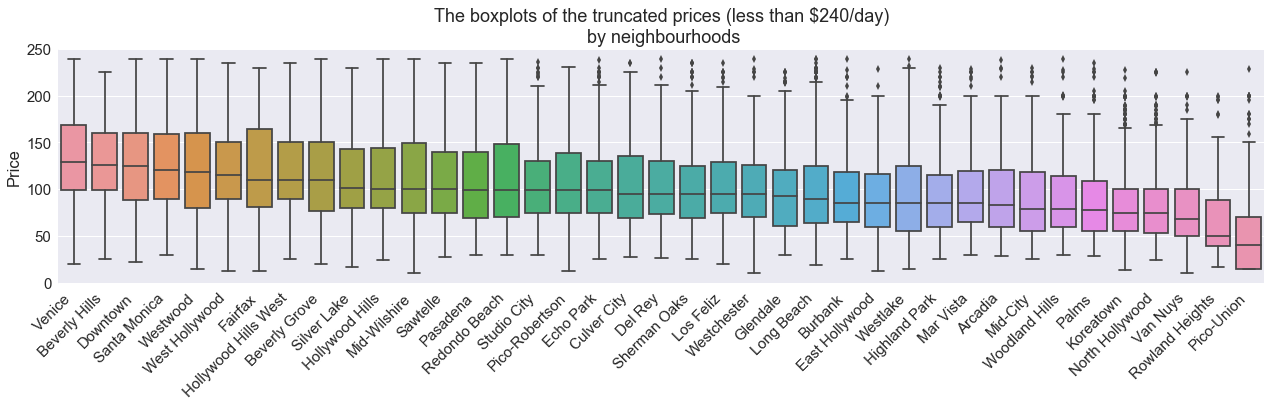

In [26]:
width = 18
height = 6
plt.figure(figsize=(width, height))
sns.set(font_scale=1.5)

ax = sns.boxplot(x='neighbourhood_cleansed', y='price', data=df_lists_cut[mask], order=price_order)

ax.set(xlabel= '', 
       ylabel='Price', \
       title="The boxplots of the truncated prices (less than ${}/day)\n by neighbourhoods".format(price_cutoff))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

plt.savefig('Fig_4_Neigbourhood.jpg')

plt.show()

In [27]:
neighb_price = df_lists_cut.loc[mask, ['neighbourhood_cleansed', 'bedrooms', 'price']].reset_index(drop=True).\
                groupby(['neighbourhood_cleansed', 'bedrooms'])['price'].mean().reset_index().\
                pivot(index='neighbourhood_cleansed', columns='bedrooms', values='price')
neighb_price

bedrooms,0.0,1.0,2.0,3.0,4.0,5.0,7.0
neighbourhood_cleansed,,,,,,,
Arcadia,60.000000,73.816176,128.172414,171.217391,NaN,NaN,NaN
Beverly Grove,115.862069,103.015576,167.271429,198.428571,230.000000,NaN,129.0
Beverly Hills,126.217391,123.850220,180.789474,187.428571,NaN,NaN,NaN
Burbank,89.108108,82.578035,145.133333,157.166667,175.000000,NaN,NaN
Culver City,94.882353,87.371069,157.100000,217.375000,216.000000,NaN,NaN
Del Rey,109.000000,91.281106,153.256410,176.125000,207.000000,NaN,NaN
Downtown,123.396947,116.805861,175.770833,171.333333,NaN,NaN,NaN
East Hollywood,81.333333,81.044369,133.300000,181.750000,NaN,NaN,NaN
Echo Park,100.633333,89.291785,156.075472,181.285714,204.500000,180.0,NaN


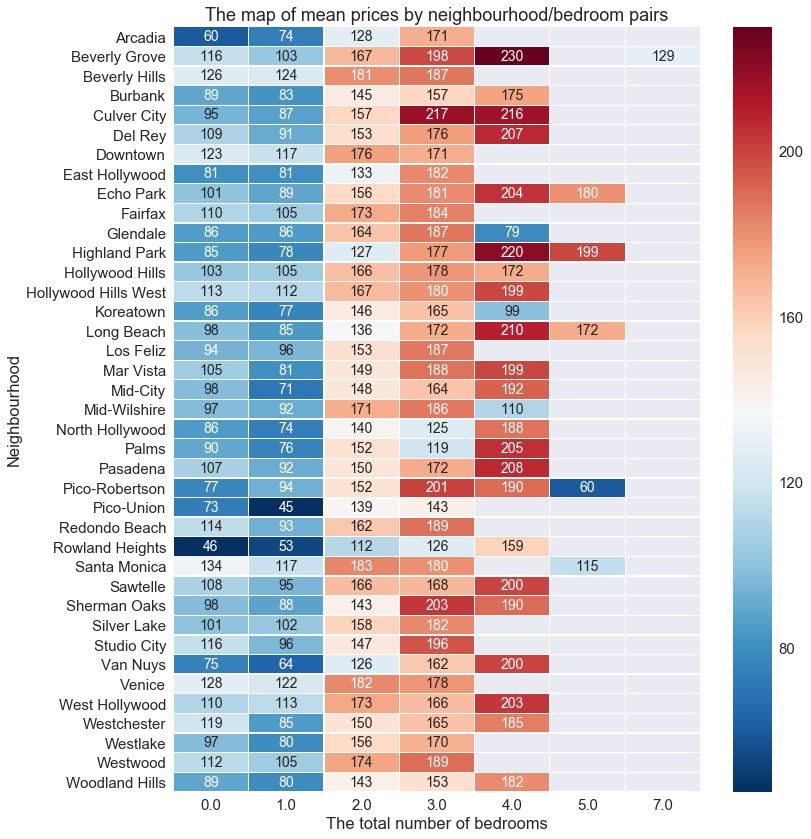

In [28]:
width = 12
height = 12
plt.figure(figsize=(width, height))

ax = sns.heatmap(neighb_price, annot=True, annot_kws={"size": 14}, fmt='.0f', cmap='RdBu_r', linewidths=0.3)

ax.set(xlabel= 'The total number of bedrooms', \
         ylabel='Neighbourhood', \
         title="The map of mean prices by neighbourhood/bedroom pairs")

plt.tight_layout()

plt.savefig('Fig_5_Prices_neighbs_bedrooms.jpg')

plt.show()

In [29]:
df_lists_cut[['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 
         'square_feet','price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee']].head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee
1,House,Private room,2,1.0,1.0,1.0,Real Bed,{},NaN,50.0,NaN,NaN,NaN,NaN
2,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Air conditioning"",""Wheel...",NaN,55.0,NaN,NaN,NaN,NaN
3,Other,Entire home/apt,6,1.0,1.0,3.0,Real Bed,"{TV,""Wireless Internet"",""Air conditioning"",Poo...",NaN,150.0,NaN,NaN,NaN,$35.00
4,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Free pa...",NaN,30.0,NaN,NaN,NaN,$5.00
5,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,35.0,NaN,NaN,NaN,NaN


In [30]:
prop_type = df_lists_cut.property_type.value_counts()
print(prop_type)

Apartment             12794
House                  9805
Condominium             764
Townhouse               648
Guesthouse              536
Loft                    455
Bungalow                428
Bed & Breakfast         317
Other                   245
Villa                   137
Dorm                    126
Camper/RV                93
Cabin                    73
Hostel                   65
Boat                     34
Guest suite              24
Boutique hotel           22
Tent                     18
Serviced apartment       14
Hut                       8
Yurt                      8
Treehouse                 7
Castle                    6
Chalet                    4
In-law                    3
Earth House               3
Tipi                      3
Vacation home             2
Cave                      1
Train                     1
Parking Space             1
Island                    1
Casa particular           1
Plane                     1
Name: property_type, dtype: int64


In [31]:
price_order = df_lists_cut.groupby('property_type')['price'].median().sort_values(ascending=False).index.values
print(price_order)

['Train' 'Tipi' 'Island' 'Treehouse' 'Castle' 'Cave' 'Serviced apartment'
 'Loft' 'Bungalow' 'Boat' 'Vacation home' 'Guesthouse' 'Parking Space'
 'Yurt' 'Boutique hotel' 'Condominium' 'Apartment' 'Other' 'Cabin' 'Chalet'
 'Guest suite' 'Townhouse' 'Camper/RV' 'House' 'Casa particular'
 'Bed & Breakfast' 'In-law' 'Hut' 'Villa' 'Plane' 'Earth House' 'Tent'
 'Dorm' 'Hostel']


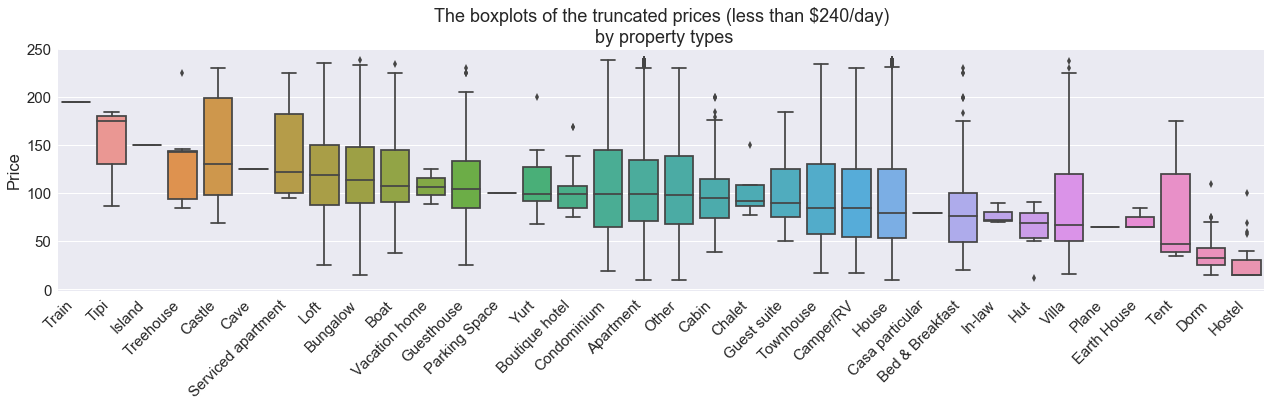

In [32]:
width = 18
height = 6
plt.figure(figsize=(width, height))
sns.set(font_scale=1.5)

ax = sns.boxplot(x='property_type', y='price', data=df_lists_cut, order=price_order)

ax.set(xlabel= '', 
       ylabel='Price', \
       title="The boxplots of the truncated prices (less than ${}/day)\n by property types".format(price_cutoff))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

plt.savefig('Fig_6_Property_type.jpg')

plt.show()

In [33]:
df_lists_cut.room_type.value_counts()

Entire home/apt    13616
Private room       11423
Shared room         1609
Name: room_type, dtype: int64

In [34]:
price_order = df_lists_cut.groupby('room_type')['price'].median().sort_values(ascending=False).index.values
print(price_order)

['Entire home/apt' 'Private room' 'Shared room']


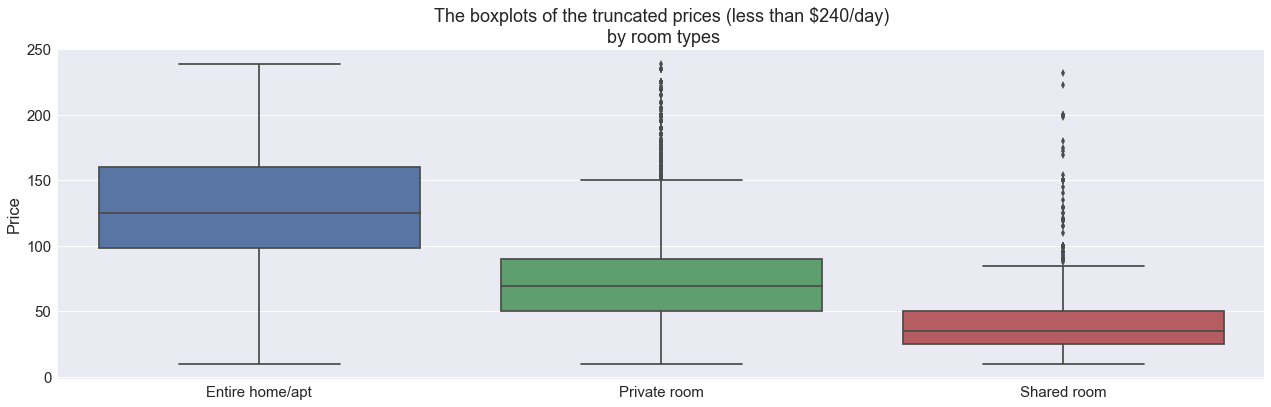

In [35]:
width = 18
height = 6
plt.figure(figsize=(width, height))
sns.set(font_scale=1.5)

ax = sns.boxplot(x='room_type', y='price', data=df_lists_cut, order=price_order)

ax.set(xlabel= '', 
       ylabel='Price', \
       title="The boxplots of the truncated prices (less than ${}/day)\n by room types".format(price_cutoff))

plt.tight_layout()

plt.savefig('Fig_7_Room_type.jpg')

plt.show()

In [36]:
df_lists_cut.bathrooms.value_counts()

1.0    21063
2.0     3007
1.5     1339
2.5      401
3.0      307
0.5      154
0.0      132
4.0       66
3.5       43
8.0       40
5.0        6
4.5        3
5.5        2
6.5        1
6.0        1
Name: bathrooms, dtype: int64

In [37]:
df_lists_cut.bedrooms.value_counts()

1.0    19317
2.0     3563
0.0     2836
3.0      772
4.0      108
5.0       15
7.0        2
6.0        1
Name: bedrooms, dtype: int64

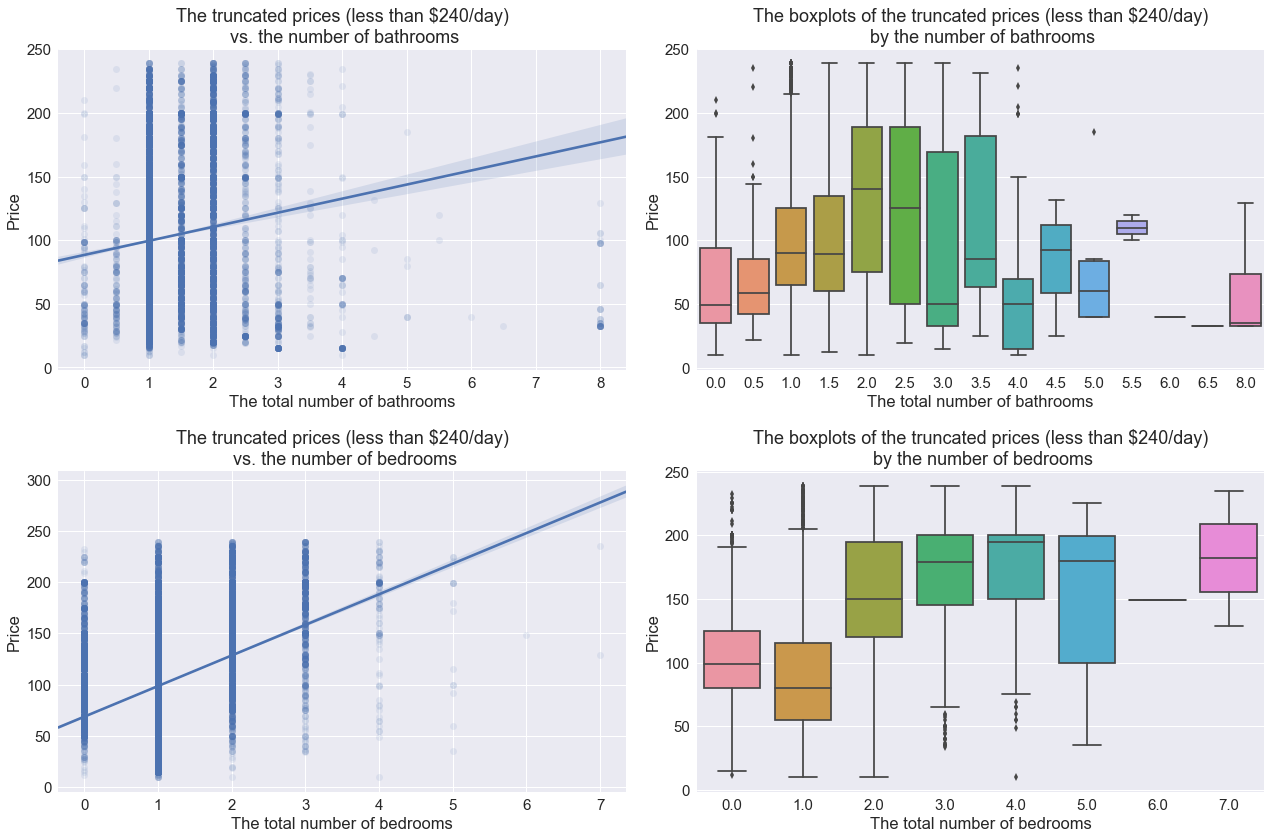

In [38]:
width = 18
height = 12
plt.figure(figsize=(width, height))
sns.set(font_scale=1.5)

plt.subplot(2, 2, 1)

ax_1 = sns.regplot(x='bathrooms', y='price', data=df_lists_cut, scatter_kws={'alpha':0.1})

ax_1.set(xlabel= 'The total number of bathrooms', \
         ylabel='Price', \
         title="The truncated prices (less than ${}/day)\n vs. the number of bathrooms".format(price_cutoff))

plt.subplot(2, 2, 2)

ax_2 = sns.boxplot(x='bathrooms', y='price', data=df_lists_cut)

ax_2.set(xlabel= 'The total number of bathrooms', 
         ylabel='Price', \
         title="The boxplots of the truncated prices (less than ${}/day)\n by the number of bathrooms".format(price_cutoff))



plt.subplot(2, 2, 3)

ax_3 = sns.regplot(x='bedrooms', y='price', data=df_lists_cut, scatter_kws={'alpha':0.1})

ax_3.set(xlabel= 'The total number of bedrooms', \
         ylabel='Price', \
         title="The truncated prices (less than ${}/day)\n vs. the number of bedrooms".format(price_cutoff))

plt.subplot(2, 2, 4)

ax_4 = sns.boxplot(x='bedrooms', y='price', data=df_lists_cut)

ax_4.set(xlabel= 'The total number of bedrooms', 
       ylabel='Price', \
       title="The boxplots of the truncated prices (less than ${}/day)\n by the number of bedrooms".format(price_cutoff))

plt.tight_layout()

plt.savefig('Fig_8_Bathrooms_bedrooms.jpg')

plt.show()

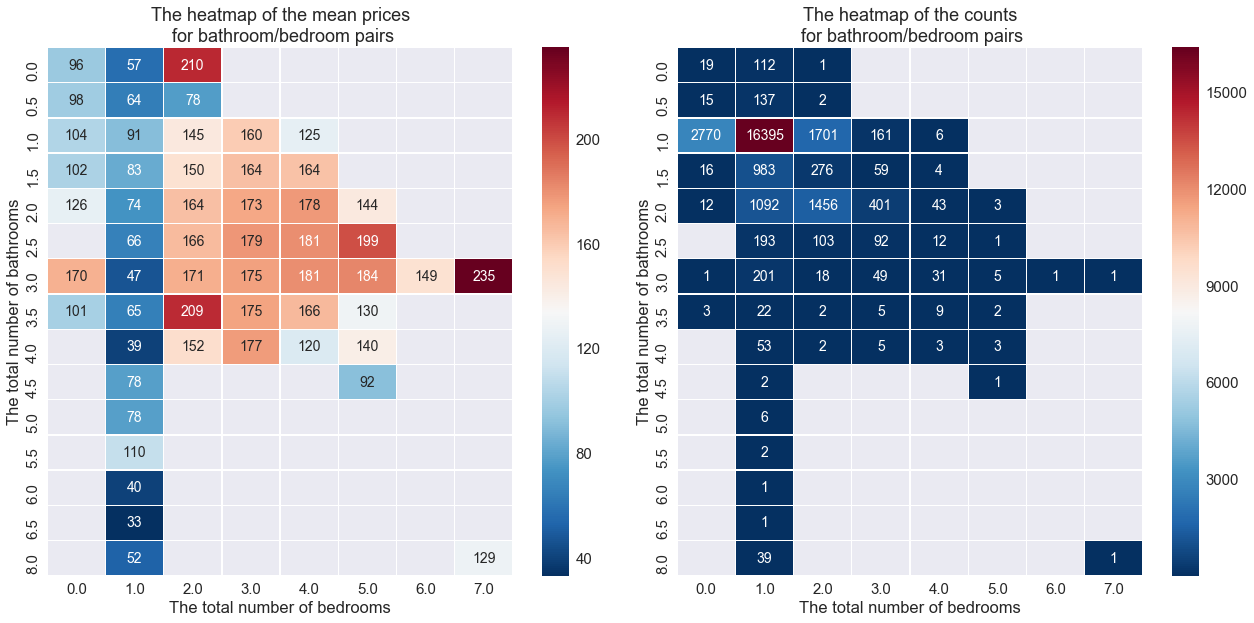

In [39]:
bath_bed_price = df_lists_cut.groupby(['bathrooms', 'bedrooms'])['price'].mean().reset_index().\
                    pivot(index='bathrooms', columns='bedrooms', values='price')
    
bath_bed_count = df_lists_cut.groupby(['bathrooms', 'bedrooms'])['price'].count().reset_index().\
                    pivot(index='bathrooms', columns='bedrooms', values='price')

width = 18
height = 9
plt.figure(figsize=(width, height))

plt.subplot(1, 2, 1)

ax_1 = sns.heatmap(bath_bed_price, annot=True, annot_kws={"size": 14}, fmt='.0f', cmap='RdBu_r', linewidths=0.3)

ax_1.set(xlabel= 'The total number of bedrooms', \
         ylabel='The total number of bathrooms', \
         title="The heatmap of the mean prices\n for bathroom/bedroom pairs")

plt.subplot(1, 2, 2)

ax_2 = sns.heatmap(bath_bed_count, annot=True, annot_kws={"size": 14}, fmt='.0f', cmap='RdBu_r', linewidths=0.3)

ax_2.set(xlabel= 'The total number of bedrooms', \
         ylabel='The total number of bathrooms', \
         title="The heatmap of the counts\n for bathroom/bedroom pairs")

plt.tight_layout()

plt.savefig('Fig_9_Bath_Bed_Heatmap.jpg')

plt.show()

In [40]:
df_lists_cut['beds'].value_counts()

1.0     17297
2.0      5932
3.0      1996
4.0       792
5.0       245
6.0       149
8.0        72
10.0       48
7.0        33
16.0       18
9.0         9
15.0        1
14.0        1
13.0        1
11.0        1
12.0        1
Name: beds, dtype: int64

In [41]:
df_lists_cut['bed_type'].value_counts()

Real Bed         25825
Futon              306
Pull-out Sofa      192
Airbed             189
Couch              136
Name: bed_type, dtype: int64

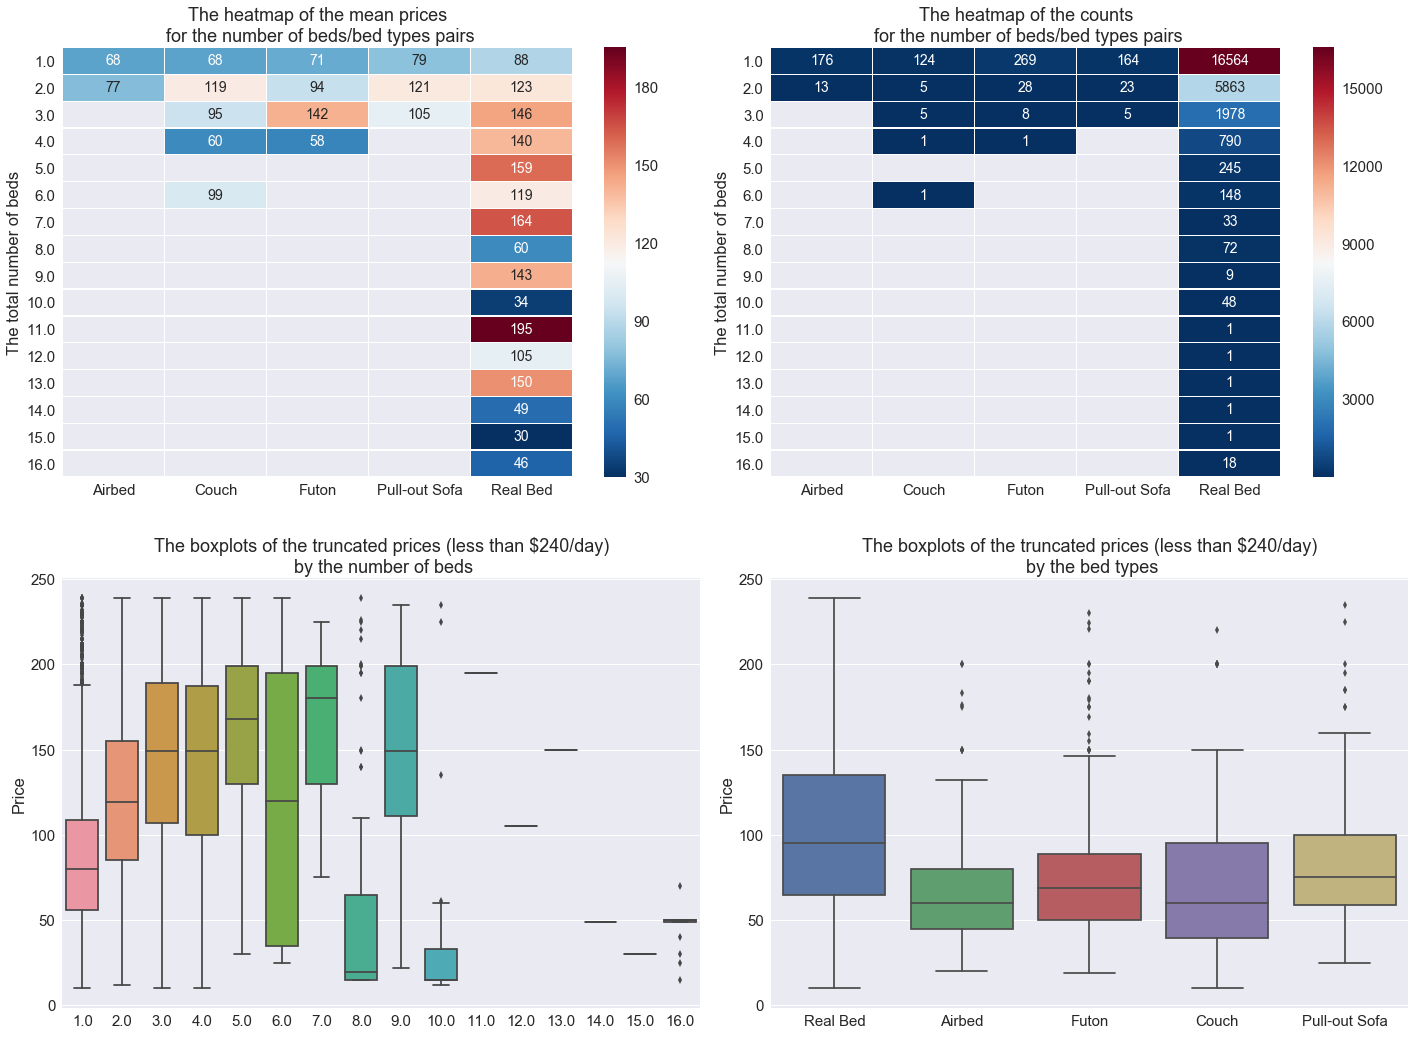

In [42]:
bed_type_price = df_lists_cut.groupby(['beds', 'bed_type'])['price'].mean().reset_index().\
                    pivot(index='beds', columns='bed_type', values='price')
    
bed_type_count = df_lists_cut.groupby(['beds', 'bed_type'])['price'].count().reset_index().\
                    pivot(index='beds', columns='bed_type', values='price')

width = 20
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2, 2, 1)

ax_1 = sns.heatmap(bed_type_price, annot=True, annot_kws={"size": 14}, fmt='.0f', cmap='RdBu_r', linewidths=0.3)

ax_1.set(xlabel=' ', \
         ylabel='The total number of beds', \
         title="The heatmap of the mean prices\n for the number of beds/bed types pairs")

ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation='horizontal')

plt.subplot(2, 2, 2)

ax_2 = sns.heatmap(bed_type_count, annot=True, annot_kws={"size": 14}, fmt='.0f', cmap='RdBu_r', linewidths=0.3)

ax_2.set(xlabel='', \
         ylabel='The total number of beds', \
         title="The heatmap of the counts\n for the number of beds/bed types pairs")

ax_2.set_xticklabels(ax_2.get_xticklabels(), rotation='horizontal')

plt.subplot(2, 2, 3)

ax_3 = sns.boxplot(x='beds', y='price', data=df_lists_cut)

ax_3.set(xlabel= ' ', 
       ylabel='Price', \
       title="The boxplots of the truncated prices (less than ${}/day)\n by the number of beds".format(price_cutoff))

plt.subplot(2, 2, 4)

ax_4 = sns.boxplot(x='bed_type', y='price', data=df_lists_cut)

ax_4.set(xlabel= ' ', 
       ylabel='Price', \
       title="The boxplots of the truncated prices (less than ${}/day)\n by the bed types".format(price_cutoff))

plt.tight_layout()

plt.savefig('Fig_10_Beds_Types_Heatmap.jpg')

plt.show()

In [43]:
df_lists_cut['amenities'].head(15)

1                                                    {}
2     {"Wireless Internet","Air conditioning","Wheel...
3     {TV,"Wireless Internet","Air conditioning",Poo...
4     {Internet,"Wireless Internet",Kitchen,"Free pa...
5     {TV,Internet,"Wireless Internet",Kitchen,"Free...
6     {Internet,"Wireless Internet","Free parking on...
7     {TV,Internet,"Wireless Internet",Kitchen,Washe...
9     {TV,"Wireless Internet","Air conditioning",Kit...
10    {TV,Internet,"Wireless Internet","Air conditio...
11    {"Cable TV",Internet,"Wireless Internet",Kitch...
12    {Internet,"Wireless Internet","Pets live on th...
13    {"Wireless Internet",Kitchen,"Free parking on ...
14    {"Wireless Internet",Kitchen,"Free parking on ...
15    {TV,"Wireless Internet",Kitchen,"Pets live on ...
16    {TV,"Wireless Internet",Kitchen,Heating,Washer...
Name: amenities, dtype: object

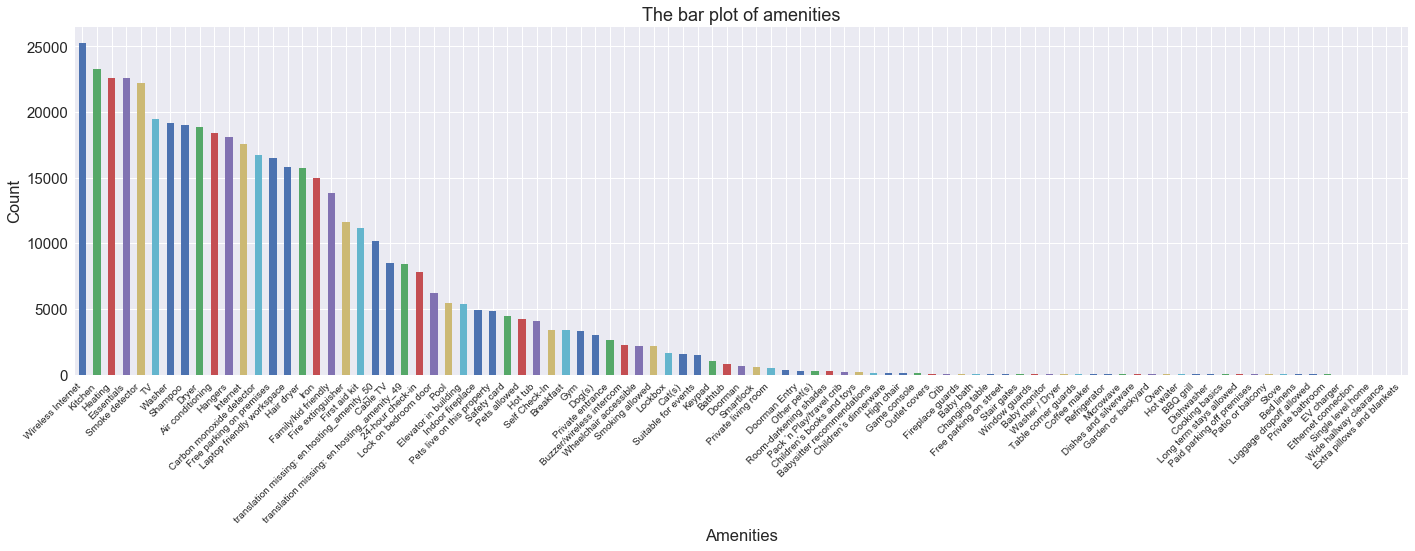

In [44]:
df_lists_cut['amenities'] = df_lists_cut['amenities'].str.replace(pat='{', repl='')
df_lists_cut['amenities'] = df_lists_cut['amenities'].str.replace(pat='}', repl='')
df_lists_cut['amenities'] = df_lists_cut['amenities'].str.replace(pat='"', repl='')
df_lists_cut['amenities'] = df_lists_cut['amenities'].str.split(',')

amn = np.concatenate(df_lists_cut['amenities'].values)
amn = pd.Series(amn)

width = 20
height = 8
plt.figure(figsize=(width, height))

ax = amn.value_counts().plot(kind='bar')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

ax.set(xlabel= 'Amenities', 
       ylabel='Count', \
       title="The bar plot of amenities")

plt.tight_layout()

plt.savefig('Fig_11_Amenities.jpg')

plt.show()

In [45]:
df_lists_cut['amenities'].head()

1                                                   []
2    [Wireless Internet, Air conditioning, Wheelcha...
3    [TV, Wireless Internet, Air conditioning, Pool...
4    [Internet, Wireless Internet, Kitchen, Free pa...
5    [TV, Internet, Wireless Internet, Kitchen, Fre...
Name: amenities, dtype: object

In [46]:
amn_unq = np.unique(amn.values)[1:]
amn_unq

array(['24-hour check-in', 'Air conditioning', 'BBQ grill', 'Baby bath',
       'Baby monitor', 'Babysitter recommendations', 'Bathtub',
       'Bed linens', 'Breakfast', 'Buzzer/wireless intercom', 'Cable TV',
       'Carbon monoxide detector', 'Cat(s)', 'Changing table',
       'Children’s books and toys', 'Children’s dinnerware',
       'Coffee maker', 'Cooking basics', 'Crib', 'Dishes and silverware',
       'Dishwasher', 'Dog(s)', 'Doorman', 'Doorman Entry', 'Dryer',
       'EV charger', 'Elevator in building', 'Essentials',
       'Ethernet connection', 'Extra pillows and blankets',
       'Family/kid friendly', 'Fire extinguisher', 'Fireplace guards',
       'First aid kit', 'Free parking on premises',
       'Free parking on street', 'Game console', 'Garden or backyard',
       'Gym', 'Hair dryer', 'Hangers', 'Heating', 'High chair', 'Hot tub',
       'Hot water', 'Indoor fireplace', 'Internet', 'Iron', 'Keypad',
       'Kitchen', 'Laptop friendly workspace', 'Lock on bedroom d

In [47]:
amn_unq.shape

(90,)

In [48]:
amn_bool = np.array([df_lists_cut['amenities'].map(lambda x: amn in x) for amn in amn_unq])
amn_bool

array([[False, False,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       ..., 
       [False,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]], dtype=bool)

In [49]:
amn_bool.shape

(90, 26648)

In [50]:
df_lists_cut.shape

(26648, 96)

In [51]:
df_lists_cut = pd.concat([df_lists_cut.reset_index(drop=True), pd.DataFrame(data=amn_bool.T, columns=amn_unq)], axis=1)
df_lists_cut.shape

(26648, 186)

In [52]:
binary_feature_names = np.array(['host_identity_verified', 'host_has_profile_pic', 'is_location_exact', 'requires_license', 
                        'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification'])

for binary_feature in binary_feature_names:
    df_lists_cut[binary_feature] = df_lists_cut[binary_feature].replace({'t':True, 'f':False})

df_lists_cut[binary_feature_names].head()

,host_identity_verified,host_has_profile_pic,is_location_exact,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,False,True,False,False,False,False,False
1,True,True,True,False,False,False,False
2,False,True,True,False,True,False,False
3,True,True,True,False,False,False,False
4,False,True,True,False,False,False,False


In [53]:
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    df_lists_cut = pd.concat([df_lists_cut, pd.get_dummies(df_lists_cut[categorical_feature])], axis=1)

df_lists_cut.shape

(26648, 478)

In [54]:
df_lists_cut.shape

(26648, 478)

In [55]:
neighbourhood_cleansed_colnames = df_lists_cut.neighbourhood_cleansed.unique()
neighbourhood_cleansed_colnames.shape[0]

250

In [56]:
property_type_colnames = df_lists_cut.property_type.unique()
property_type_colnames.shape[0]

34

In [57]:
room_type_colnames = df_lists_cut.room_type.unique()
room_type_colnames.shape[0]

3

In [58]:
bed_type_colnames = df_lists_cut.bed_type.unique()
bed_type_colnames.shape[0]

5

In [59]:
188 + 253 + 35 + 3 + 5

484

In [60]:
categorical_features_names = np.concatenate((amn_unq, neighbourhood_cleansed_colnames, property_type_colnames, 
                                             room_type_colnames, bed_type_colnames))
binary_feature_names = np.concatenate((np.array(['host_is_superhost']), binary_feature_names))
numerical_feature_names = np.array(['host_listings_count', 'host_total_listings_count', 'accommodates', 
                                    'bathrooms', 'bedrooms', 'beds', 'guests_included', 'number_of_reviews', 
                                    'review_scores_rating'])

predictors = np.concatenate((categorical_features_names, binary_feature_names, numerical_feature_names))
target = 'price'

In [61]:
df_lists_cut[predictors].head()

,24-hour check-in,Air conditioning,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Bathtub,Bed linens,Breakfast,Buzzer/wireless intercom,...,require_guest_phone_verification,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,number_of_reviews,review_scores_rating
0,False,False,False,False,False,False,False,False,False,False,...,False,1.0,1.0,2,1.0,1.0,1.0,1,33,93.0
1,False,True,False,False,False,False,False,False,False,False,...,False,1.0,1.0,2,1.0,1.0,1.0,1,14,100.0
2,True,True,False,False,False,False,False,False,True,False,...,False,1.0,1.0,6,1.0,1.0,3.0,1,22,100.0
3,False,False,False,False,False,False,False,False,False,False,...,False,1.0,1.0,1,1.0,1.0,1.0,1,3,93.0
4,False,False,False,False,False,False,False,False,False,False,...,False,1.0,1.0,1,1.0,1.0,1.0,1,0,NaN


In [62]:
df_lists_cut[predictors].shape

(26648, 399)

In [63]:
df_lists_cut[predictors].isnull().sum().sort_values(ascending=False)[0:10]

review_scores_rating         6002
bathrooms                      83
beds                           52
bedrooms                       34
host_listings_count            12
host_identity_verified         12
host_has_profile_pic           12
host_is_superhost              12
host_total_listings_count      12
Culver City                     0
dtype: int64

In [64]:
predictors = predictors[predictors != 'review_scores_rating']
predictors.shape[0]

398

In [65]:
mask = df_lists_cut['host_listings_count'].isnull()
df_lists_cut[~mask][predictors].isnull().sum().sort_values(ascending=False)[0:5]

bathrooms            83
beds                 52
bedrooms             34
number_of_reviews     0
Carson                0
dtype: int64

In [66]:
df_lists_cut = df_lists_cut[~mask].reset_index()
df_lists_cut[predictors].isnull().sum().sort_values(ascending=False)[0:5]

bathrooms            83
beds                 52
bedrooms             34
number_of_reviews     0
Carson                0
dtype: int64

In [67]:
median_bathrooms = df_lists_cut['bathrooms'].median()
median_beds = df_lists_cut['beds'].median()
median_bedrooms = df_lists_cut['bedrooms'].median()

df_lists_cut['bathrooms'] = df_lists_cut['bathrooms'].fillna(median_bathrooms)
df_lists_cut['beds'] = df_lists_cut['beds'].fillna(median_beds)
df_lists_cut['bedrooms'] = df_lists_cut['bedrooms'].fillna(median_bedrooms)

df_lists_cut[predictors].isnull().sum().sort_values(ascending=False)[0:5]

number_of_reviews    0
Beverly Crest        0
Boyle Heights        0
Bradbury             0
Central-Alameda      0
dtype: int64

In [68]:
X = df_lists_cut[predictors]
y = df_lists_cut[target]

y_mean = np.full(y.shape, y.mean())
rmse_baseline = (mean_squared_error(y, y_mean))**(1/2)
rmse_baseline

49.908557475826377

In [69]:
r2_baseline = r2_score(y, y_mean)
r2_baseline

0.0

In [70]:
reg = LinearRegression()

reg.fit(X, y)

y_pred = reg.predict(X)

rmse = (mean_squared_error(y, y_pred))**(1/2)
rmse

30.883168488773027

In [71]:
r2_score(y, y_pred)

0.61709268187772093

In [72]:
reg.coef_

array([  2.11936424e-01,   2.20493003e+00,   1.54138702e+12,
         5.50883494e+00,  -1.91052641e+01,   2.26487113e-01,
        -1.18200821e+00,  -5.77080434e+10,   2.65638339e-01,
         2.05959320e+00,   4.53562927e+00,   8.06060791e-01,
        -3.12013245e+00,  -1.33373308e+00,  -2.78675365e+00,
         1.84557343e+00,   3.09519231e+10,   2.88137527e+11,
        -5.41794252e+00,  -4.36036155e+11,  -3.82320896e+11,
         1.08310699e-01,   3.07757187e+00,   6.59669876e-01,
         5.13669586e+00,  -1.43318098e+11,   3.93676376e+00,
        -2.15536499e+00,  -1.35382847e+11,  -1.33843441e+11,
        -2.27432251e-01,   8.92120361e-01,   9.77425814e-01,
         5.53024292e-01,   4.65951538e+00,  -6.62193605e+00,
        -3.97914135e+00,  -4.35252428e+11,   3.24458694e+00,
         1.21496582e+00,  -9.55810547e-01,   7.57141113e-01,
         2.29323864e+00,   4.08179092e+00,  -2.88137527e+11,
         3.75496483e+00,  -2.20828247e+00,  -1.16326904e+00,
         2.94441223e-01,

In [73]:
coefs = np.array(list(zip(X.columns, reg.coef_)))
coefs

array([['24-hour check-in', '0.2119364239'],
       ['Air conditioning', '2.20493002823'],
       ['BBQ grill', '1.54138702038e+12'],
       ['Baby bath', '5.50883494079'],
       ['Baby monitor', '-19.105264111'],
       ['Babysitter recommendations', '0.226487112702'],
       ['Bathtub', '-1.18200821294'],
       ['Bed linens', '-57708043435.9'],
       ['Breakfast', '0.265638339315'],
       ['Buzzer/wireless intercom', '2.05959320068'],
       ['Cable TV', '4.53562927246'],
       ['Carbon monoxide detector', '0.806060791016'],
       ['Cat(s)', '-3.12013244629'],
       ['Changing table', '-1.33373308182'],
       ['Children’s books and toys', '-2.78675365448'],
       ['Children’s dinnerware', '1.84557342529'],
       ['Coffee maker', '30951923075.5'],
       ['Cooking basics', '288137527126.0'],
       ['Crib', '-5.41794252396'],
       ['Dishes and silverware', '-436036155287.0'],
       ['Dishwasher', '-382320896184.0'],
       ['Dog(s)', '0.108310699463'],
       ['Doorman', 

In [74]:
coeff_cutoff = 7
mask_1 = np.array([(abs(x[1].astype('float32')) < coeff_cutoff) for x in coefs])

mask_2 = X.columns.isin(amn_unq)

mask = np.logical_and(mask_1, mask_2)
coefs[mask]

array([['24-hour check-in', '0.2119364239'],
       ['Air conditioning', '2.20493002823'],
       ['Baby bath', '5.50883494079'],
       ['Babysitter recommendations', '0.226487112702'],
       ['Bathtub', '-1.18200821294'],
       ['Breakfast', '0.265638339315'],
       ['Buzzer/wireless intercom', '2.05959320068'],
       ['Cable TV', '4.53562927246'],
       ['Carbon monoxide detector', '0.806060791016'],
       ['Cat(s)', '-3.12013244629'],
       ['Changing table', '-1.33373308182'],
       ['Children’s books and toys', '-2.78675365448'],
       ['Children’s dinnerware', '1.84557342529'],
       ['Crib', '-5.41794252396'],
       ['Dog(s)', '0.108310699463'],
       ['Doorman', '3.0775718689'],
       ['Doorman Entry', '0.659669876099'],
       ['Dryer', '5.13669586182'],
       ['Elevator in building', '3.93676376343'],
       ['Essentials', '-2.15536499023'],
       ['Family/kid friendly', '-0.227432250977'],
       ['Fire extinguisher', '0.892120361328'],
       ['Fireplace gua

In [75]:
amn_names = [x[0] for x in coefs[mask]]
amn_coefs = [x[1] for x in coefs[mask]]
amn_fit = pd.DataFrame({'Amenity':amn_names, 'Coefficient':amn_coefs})
amn_fit.head()

,Amenity,Coefficient
0,24-hour check-in,0.2119364239
1,Air conditioning,2.20493002823
2,Baby bath,5.50883494079
3,Babysitter recommendations,0.226487112702
4,Bathtub,-1.18200821294


In [76]:
amn_fit['Amenity'] = amn_fit.Amenity.astype('category')
amn_fit['Coefficient'] = amn_fit.Coefficient.astype('float32')
amn_fit = amn_fit.sort_values(by=['Coefficient']).reset_index(drop=True)
amn_fit.head()

,Amenity,Coefficient
0,Outlet covers,-6.930919
1,Free parking on street,-6.621936
2,Crib,-5.417943
3,Window guards,-4.936293
4,Game console,-3.979141


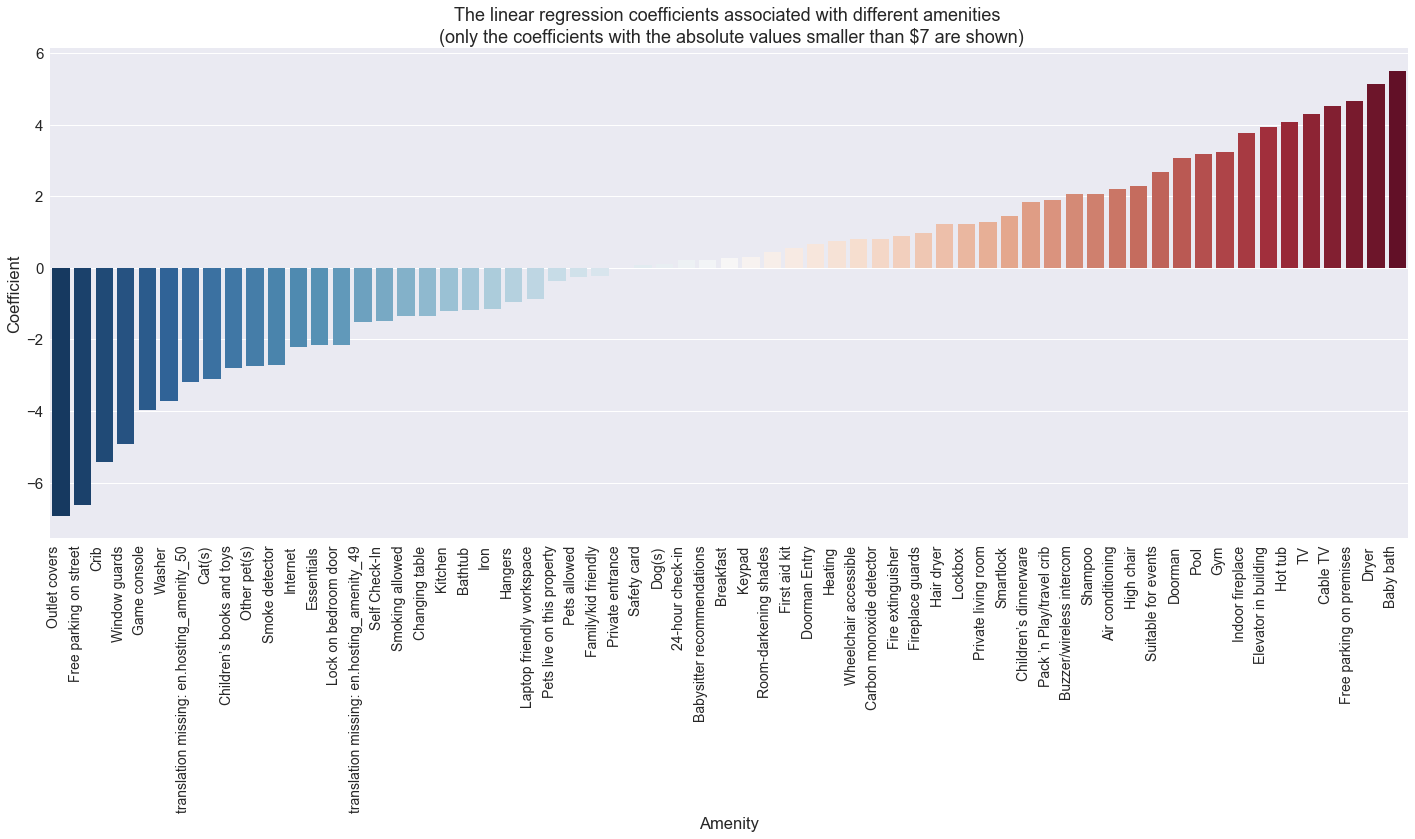

In [77]:
width = 20
height = 12
plt.figure(figsize=(width, height))

ax = sns.barplot(x='Amenity', y='Coefficient', data=amn_fit, order=amn_fit.Amenity, palette="RdBu_r") 
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical', ha='right', fontsize=14)

plt.title('The linear regression coefficients associated with different amenities \n \
(only the coefficients with the absolute values smaller than $7 are shown)')

plt.tight_layout()

plt.savefig('Fig_12_Coeffs_Amenities.jpg')

plt.show()